# 利用深度神经网络进行时间序列分析预测

In [31]:
import pandas as pd

In [32]:

import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import itertools
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from math import sqrt
from numpy import array
from numpy import split
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.regularizers import L1L2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import warnings
warnings.filterwarnings('ignore')


In [33]:
df_user_num=pd.read_csv("list_user_num.csv",encoding='gbk')

In [34]:
user_data_2015_2017=pd.read_csv("CleanedPowerConsumingData_2015_2017.csv")

In [35]:
user_data_2015_2017.shape

(3728861, 42)

In [36]:
user_data_monthly_2015_2017=pd.read_csv("CleanedPowerConsumingData_monthly_2015_2017.csv",encoding="gbk")

In [37]:
user_data_monthly_2015_2017.shape

(128292, 45)

## 时间序列预测

In [38]:
monthlyData = user_data_monthly_2015_2017[user_data_monthly_2015_2017['编号']==64614]  #衡阳华菱钢管有限公司
dailyData=user_data_2015_2017[user_data_2015_2017['编号']==64614].iloc[:,1:]

In [39]:
monthlyData.describe()

,编号,HOUR1,HOUR2,HOUR3,HOUR4,HOUR5,HOUR6,HOUR7,HOUR8,HOUR9,...,平段用电量占比,谷段用电量占比,尖峰平均负荷,高峰平均负荷,平段平均负荷,谷段平均负荷,尖峰日均用电量,高峰日均用电量,平段日均用电量,谷段日均用电量
count,24.0,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,...,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,2.400000e+01
mean,64614.0,3.050850e+06,3.099831e+06,3.117981e+06,3.128369e+06,3.142731e+06,3.150431e+06,3.076700e+06,3.050269e+06,2.974919e+06,...,0.250157,0.342648,95447.661421,97001.068723,99056.609320,101704.952109,286342.984262,679007.481059,594339.655918,8.136396e+05
std,0.0,6.691886e+05,7.049126e+05,6.953340e+05,6.933053e+05,6.840565e+05,7.082185e+05,6.950356e+05,6.703648e+05,6.695935e+05,...,0.002781,0.004764,19462.581756,21114.565967,21783.445801,22143.025263,58387.745269,147801.961771,130700.674805,1.771442e+05
min,64614.0,1.188000e+06,1.188000e+06,1.267200e+06,1.214400e+06,1.214400e+06,1.188000e+06,1.240800e+06,1.135200e+06,1.293600e+06,...,0.242015,0.332478,38606.451613,38200.921659,38180.645161,39333.870968,115819.354839,267406.451613,229083.870968,3.146710e+05
25%,64614.0,2.927100e+06,3.062400e+06,3.012900e+06,3.069000e+06,3.121800e+06,3.062400e+06,3.009600e+06,2.970000e+06,2.943600e+06,...,0.248645,0.339254,94209.677419,96409.849254,98692.673592,101321.975806,282629.032258,674868.944779,592156.041553,8.105758e+05
50%,64614.0,3.214200e+06,3.300000e+06,3.379200e+06,3.438600e+06,3.319800e+06,3.353173e+06,3.280200e+06,3.293400e+06,3.180827e+06,...,0.250489,0.342240,99963.133641,103826.530612,105316.129032,108917.741935,299889.400922,726785.714286,631896.774194,8.713419e+05
75%,64614.0,3.412200e+06,3.498000e+06,3.517800e+06,3.530441e+06,3.527700e+06,3.514500e+06,3.484800e+06,3.366000e+06,3.372600e+06,...,0.251925,0.345281,107963.225806,108279.539171,110073.333333,113363.601671,323889.677419,757956.774194,660440.000000,9.069088e+05
max,64614.0,3.942400e+06,3.889600e+06,3.854400e+06,3.819200e+06,3.942400e+06,3.889600e+06,3.819200e+06,3.990800e+06,3.696000e+06,...,0.254442,0.352374,119093.333333,122508.571429,124691.111111,127664.166667,357280.000000,857560.000000,748146.666667,1.021313e+06


In [40]:
# 将数据集拆分为训练集和测试集
def split_dataset(data):
    # 后360天用于测试
    train, test = data[:-360], data[-360:]
    train = array(split(array(train), len(train)/10))
    test = array(split(array(test), len(test)/10))
    return train, test

In [41]:
dailyData_consuming=dailyData.iloc[10:,-10:-1]  #预测这几个属性：日用电量	尖峰用电量占比	高峰用电量占比	平段用电量占比	谷段用电量占比	尖峰平均负荷	高峰平均负荷	平段平均负荷	谷段平均负荷

train,test=split_dataset(dailyData_consuming)

In [42]:
dailyData_consuming.shape

(720, 9)

In [43]:
train.shape

(36, 10, 9)

In [44]:
def prepare_rnn_data(train, n_input=30, n_out=10,i_FEATURES=0): #按照X取30的数据，y为紧接着的10天数据的样式，构建模型的输入和输出 X的shape为[:,30,1], y的shape为[,10]
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # 按照时间跨度，以遍历方式构建数据信
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
       
        if out_end < len(data):
            x_input = data[in_start:in_end, i_FEATURES]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end,i_FEATURES])
        
        in_start += 1
    return array(X), array(y)

In [45]:
# 定义训练模型
def build_model(train,n_input=30, n_out=10,i_FEATURES=0):
    # prepare data
    train_x, train_y = prepare_rnn_data(train, n_input,n_out,i_FEATURES)
    # define parameters
    verbose, epochs, batch_size = 0,200, 90
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features), bias_regularizer=L1L2(l1=0.01, l2=0.01)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [46]:
# 定义带卷积的训练模型
def build_model_cnn(train,n_input=30, n_out=10,i_FEATURES=0):
    # prepare data
    train_x, train_y = prepare_rnn_data(train, n_input,n_out,i_FEATURES)
    # define parameters
    verbose, epochs, batch_size = 0, 200, 90
    n_list,n_timesteps, n_features, n_outputs = train_x.shape[0],train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True, bias_regularizer=L1L2(l1=0.01, l2=0.01)))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [47]:
# 进行预测
def forecast(model, history, n_input,i_FEATURES=0):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, i_FEATURES]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    #print("yhat in forecast is:",yhat," his shape is:",yhat.shape)
    yhat = yhat[0]
    return yhat

In [48]:
# 评价模型
def evaluate_model(train, test, n_input,n_out,i_FEATURES=0):
    # fit model
    model = build_model(train, n_input,n_out,i_FEATURES)
    
    history = [x for x in train]
    
    predictions = list()
    for i in range(len(test)):
        # predict 
        yhat_sequence = forecast(model, history, n_input,i_FEATURES)
        #print("yhat is:",yhat_sequence,"shape of yhat is:",yhat_sequence.shape)
        # store the predictions
        predictions.append(yhat_sequence)
        
        # get real observation and add to history for predicting the next period
        history.append(test[i,:])
    # evaluate predictions days for each period
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, i_FEATURES], predictions)
    return score, scores, predictions

In [49]:
test.shape

(36, 10, 9)

In [50]:
# 评价带卷积的LSTM模型
def evaluate_model_cnn(train, test, n_input,n_out,i_FEATURES=0):
    # fit model
    model = build_model_cnn(train, n_input,n_out,i_FEATURES)
    history = [x for x in train]
    # walk-forward validation over each period
    predictions = list()
    for i in range(len(test)):
        # predict  
        yhat_sequence = forecast(model, history, n_input,i_FEATURES)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next period
        history.append(test[i, :])
    # evaluate predictions days for each period
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :,i_FEATURES], predictions)
    return score, scores, predictions

In [51]:
# 评价预测结果
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]): #计算相同Weekday的MSE，再构建成一个scores列表
        # calculate mse
        #print("actual[:, i]:",actual[:, i])
        #print("predicted[:,i] is:",predicted[:, i])
        mse = mean_squared_error(actual[:, i], predicted[:, i])

        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
# calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [52]:
# 汇总评价结果
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))
    

In [53]:
n_input = 10
n_out=10
i_features=0  #预测第几个特征 0:日用电量,1:尖峰用电量占比,2:高峰用电量占比,3:平段用电量占比,4:谷段用电量占比,5:尖峰平均负荷,6:高峰平均负荷,7:平段平均负荷,8:谷段平均负荷
score, scores, predictions = evaluate_model(train, test, n_input,n_out,i_features)
score_cnn, scores_cnn, predictions_cnn = evaluate_model_cnn(train, test, n_input,n_out,i_features)

#print(predictions)
print(len(train))
print(len(test))
print(len(predictions))

# summarize scores
summarize_scores('lstm', score, scores)
summarize_scores('lstm_cnn', score_cnn, scores_cnn)

36
36
36
lstm: [787983.525] 663967.0, 690443.7, 660130.3, 745053.3, 784912.2, 809440.7, 869875.3, 871761.8, 850536.7, 888478.0
lstm_cnn: [739742.488] 610851.6, 617060.2, 607656.6, 738126.2, 770455.4, 818219.2, 791639.7, 810685.0, 770120.6, 814945.8


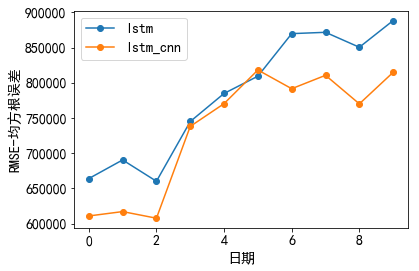

In [54]:
# plot scores
days =[x for x in range(10)]

pyplot.rcParams['font.size'] = 14
pyplot.rcParams['font.sans-serif'] = ['SimHei']
pyplot.rcParams['axes.unicode_minus'] = False
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.plot(days, scores_cnn, marker='o', label='lstm_cnn')
pyplot.legend()
pyplot.xlabel('日期')
pyplot.ylabel('RMSE-均方根误差')
pyplot.show()

(36, 10)
360
360


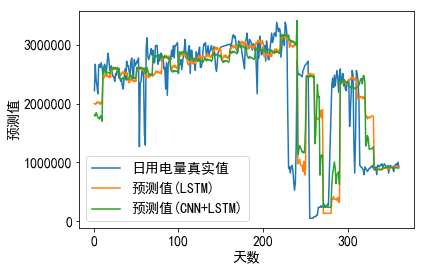

In [55]:
print(predictions.shape)
x_values = []
y_values = []
y_values_cnn = []
for i in range(len(test)):
    for j in range(10):
        x_values.append(test[i, j, i_features])
        y_values.append(predictions[i, j])
        y_values_cnn.append(predictions_cnn[i, j])
print(len(x_values))
print(len(y_values))
pyplot.plot(range(1,len(x_values)+1), x_values, label = '日用电量真实值')
pyplot.plot(range(1,len(y_values)+1), y_values, label = '预测值(LSTM)')
pyplot.plot(range(1,len(y_values_cnn)+1), y_values_cnn, label = '预测值(CNN+LSTM)')
pyplot.legend()
pyplot.xlabel('天数')
pyplot.ylabel('预测值')
pyplot.show()